In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [32]:
data_path = 'data/'
# Load track data from csv file
track_data = pd.read_csv(os.path.join(data_path, 'Budapest-track.csv'))

racing_line_data = pd.read_csv(os.path.join(data_path, 'Budapest-raceline.csv'))

racing_line_data.shape

(864, 2)

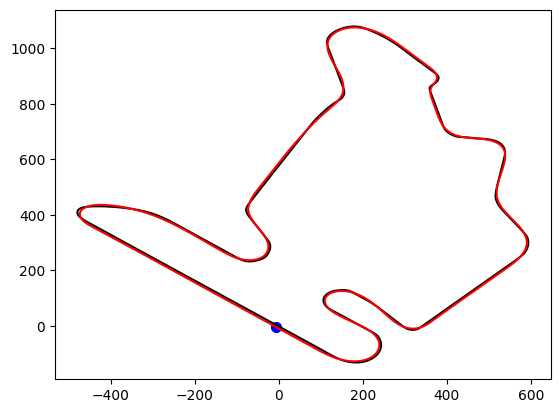

In [29]:
# Plot data points
fig, ax = plt.subplots()
ax.plot(track_data['x_m'], track_data['y_m'], 'k') # Track centerline
ax.plot(racing_line_data['x_m'], racing_line_data['y_m'], 'r') # Racing line

Pour dessiner les limites de la pistes on doit calculer les points appartenant à la ligne de limtie de gauche et de droite.
Pour se faire on a les distances à gauche à droite de la ligne du centre.

A partir d'un point de la ligne central on doit trouver les 2 points des limites correspondants. Pour définir la gauche et la droite on doit connaitre le direction du point.
La direction du point est définie par le vecteur $v_i$ formé par ce point $p_i$ et le point suivant $p_{i+1}$.

$$
    v_d = v_{i+1} - v_i
$$

In [64]:
track_data.iloc[0][['x_m', 'y_m']]

x_m   -2.447973
y_m    0.125932
Name: 0, dtype: float64

In [104]:
def calculate_track_edge(data_point, next_data_point):
    v1 = data_point[['x_m', 'y_m']]
    v2 = next_data_point[['x_m', 'y_m']]
    d_left = data_point['w_tr_left_m']
    d_right = data_point['w_tr_right_m']

    v_direction = v2 - v1
    v_direction = v_direction / np.linalg.norm(v_direction) # normalize
    v_orthogonal = pd.Series(
        {
            'x_m': -v_direction['y_m'],
            'y_m': v_direction['x_m']
        }
    )

    left_edge = v1 + v_orthogonal * d_left
    right_edge = v1 - v_orthogonal * d_right

    return left_edge, right_edge

def apply_calculate_track_edge(data_point):
    next_data_point = pd.DataFrame(
        {
            'x_m': [data_point['next_x_m']],
            'y_m': [data_point['next_y_m']]
        }
    )
    left_edge, right_edge = calculate_track_edge(data_point, next_data_point.iloc[0])
    return left_edge[0], left_edge[1], right_edge[0], right_edge[1]

def calculate_track_edges(track_data):
    track_data = track_data.copy()
    track_data[['next_x_m', 'next_y_m']] = track_data[['x_m', 'y_m']].shift(-1).fillna(track_data[['x_m', 'y_m']].iloc[0])
    track_data[['left_edge_x_m', 'left_edge_y_m', 'right_edge_x_m', 'right_edge_y_m']] = track_data.apply(apply_calculate_track_edge, axis=1, result_type='expand')

    return track_data.drop(columns=['next_x_m', 'next_y_m', 'w_tr_left_m', 'w_tr_right_m'])

In [106]:
track_data = calculate_track_edges(track_data)

In [110]:
def draw_track(center_x, center_y, width, height):
    # Plot data points
    fig, ax = plt.subplots()
    ax.set_xlim(center_x - width / 2, center_x + width / 2)
    ax.set_ylim(center_y - height / 2, center_y + height / 2)

    ax.plot(track_data['x_m'], track_data['y_m'], 'k') # Track centerline
    #ax.plot(racing_line_data['x_m'], racing_line_data['y_m'], 'r') # Racing line
    ax.plot(track_data['left_edge_x_m'], track_data['left_edge_y_m'], 'k') # Left edge
    ax.plot(track_data['right_edge_x_m'], track_data['right_edge_y_m'], 'k') # Right edge
    return fig, ax

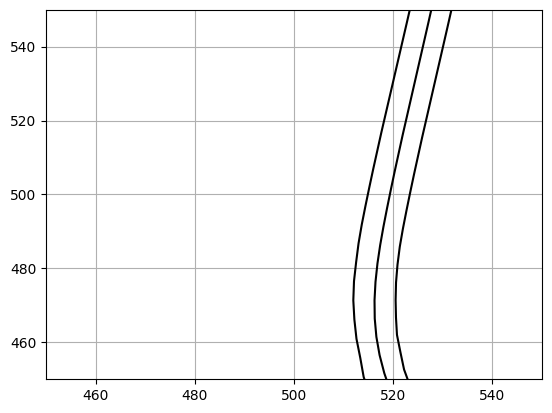

In [116]:
p1 = racing_line_data.iloc[0]
p2 = racing_line_data.iloc[1]

fig, ax = draw_track(500, 500, 100, 100)

ax.scatter(p1['x_m'], p1['y_m'], 50, 'b')
ax.scatter(p2['x_m'], p2['y_m'], 50, 'b')
ax.grid()

On a une résolution de 864 points par tour pour Budapest. On peut essayer de calculer la distance en metres entre chaques points avec la distance euclidiène.